<div class="alert"  style="background-color:#1f2e6b; color:white; padding:0px 5px; border-radius:10px;"><h2 style='margin:10px'>TF-IDF</h2></div>

# Model overview

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents. 

The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the collection. This means that words that appear frequently in the document but also frequently in the collection will be weighted down.

These scores will be paired with K-Means clustering, which groups similar documents into clusters.

1. **TF-IDF Vectorization**: First, the text data is transformed into a numerical format using TF-IDF vectorization. This process converts a collection of documents into a matrix of TF-IDF features. Each document is represented as a vector, where each dimension corresponds to a unique word in the corpus, and the value in each dimension represents the TF-IDF score of that word in the document. This score reflects how important a word is to a document in the context of the entire corpus, helping to highlight words that are distinctive for certain documents.

2. **K-Means Clustering**: The reduced or original TF-IDF matrix is then used as input for K-Means clustering. K-Means is an iterative algorithm that partitions the documents into a predefined number of \(K\) clusters. It does this by minimizing the variance within each cluster and maximizing the variance between clusters. The algorithm starts with randomly selected centroids and assigns each document to the nearest centroid based on the cosine similarity or Euclidean distance between the document's TF-IDF vector and the centroid. It then recalculates the centroids as the mean of the vectors in each cluster and repeats the assignment and update steps until the positions of the centroids stabilize or a maximum number of iterations is reached.

3. **Interpreting Clusters**: Each cluster formed by K-Means is analyzed to understand the common themes or topics within. The most representative terms for each cluster can be identified by looking at the highest TF-IDF scores within the documents of that cluster or by examining the centroids' dimensions directly.

This notebook will focus on applying the TF-IDF model with my filtered dataset. 

As a reminder, this is what my dataset looks like:

In [28]:
import pandas as pd

df = pd.read_csv("full.csv")

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63503 entries, 0 to 63502
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Job Title    63503 non-null  object
 1   Description  63503 non-null  object
 2   Category_1   63503 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB


In [29]:
df.head()

,Job Title,Description,Category_1
0,Power bi specialist freelance,Already data pooled and designed. Need to refi...,Data Analysis
1,Case Study (on-demand delivery startup),"Hi,\n\nWould you be able to help me do a case-...",Google Data Studio
2,"File Maker Pro Reports, Charts, Query and Ongo...",NITIAL PROJECT\n\nSet up Monthly Report mimick...,Report Writing
3,Implementation of EleutherAI/gpt-neox-20b,"As a first step, you will implement the instal...",Machine Learning Model
4,BI and Data Engineer for Upwork Finance System...,The Upwork Finance Systems team is looking for...,Data Analysis


The dataframe consists of 3 columns and 63503 rows. The column of interest is the description column, based on the Category_1 that houses it.

# Importing the necessary libraries

This model will be using Scikit-learn's TfidfVectorizer to convert the text data into a matrix of TF-IDF features. It will also use KMeans to cluster the data, which will produce the clusters that will be seen by the end user. 

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize

import string
import json
import glob
import re
import pandas as pd


The first function that will be defined is a text cleaning function. It will remove any punctuation, numbers, and stop words from the text.

In [132]:
def remove_stops_nltk(text, additional_stops=None):

    if additional_stops is None:
        additional_stops = []

    # Combine NLTK's stopwords with any additional stops provided
    stops = set(stopwords.words('english') + additional_stops)

    # Tokenize the text into words
    words = word_tokenize(text)

    # Remove stopwords and punctuation
    filtered_words = [word for word in words if word.lower() not in stops and word not in string.punctuation]

    # Join the words back into a string
    final_text = " ".join(filtered_words)

    return final_text

In [133]:
def clean_docs(docs, additional_stops=None):
    final = []
    for doc in docs:
        # Use remove_stops_nltk to clean each document
        clean_doc = remove_stops_nltk(doc, additional_stops)
        final.append(clean_doc)
    return final

Now, let's make it so that the dataset can be dynamically filtered based on the category that the user selects. This will be done by saving all of the top 20 categories, and programatically filter the dataset based on an index.

In [134]:
full_df_index = df["Category_1"].value_counts().head(20).index
full_df_index 

Index(['Web Development', 'Social Media Marketing', 'Marketing Strategy',
       'Mobile App Development', '3D Modeling', 'Email Marketing', 'Python',
       'Android App Development', '3D Design', 'Market Research',
       '3D Rendering', 'WordPress', 'Data Scraping', '3D Animation',
       'Lead Generation', 'Data Analysis', 'JavaScript', 'React', 'Shopify',
       'Sales & Marketing'],
      dtype='object', name='Category_1')

In [ ]:
# Dynamically choose the category that the user wants based on the selected index
curr_index = 1

condition = df["Category_1"] == full_df_index[curr_index]
current_df = df[condition]
current_df = current_df["Description"].tolist()
current = current_df

additional_words = ["like", "needed", "need", "looking", "help"]
additional_words.extend(full_df_index[curr_index].lower().split()) # adds the category name to the list of additional words to be removed by the tokenizer

descriptions = current

current_df,additional_words

Some additional stop words will be manually added, and the rest will be appeneded depending on the current topic that is being research. The approach will be to add words that mention the name of the category.

In [137]:
cleaned_docs = clean_docs(descriptions, additional_words)

vectorizer = TfidfVectorizer(
                                lowercase=True,
                                max_features=100,
                                max_df=0.8,
                                min_df=5,
                                ngram_range = (1,3),
                                stop_words = "english"
                            )

vectors = vectorizer.fit_transform(cleaned_docs)

feature_names = vectorizer.get_feature_names_out()

dense = vectors.todense()
denselist = dense.tolist()

In [144]:
curr_k = 5

model = KMeans(n_clusters=curr_k, max_iter=100, n_init=1)

model.fit(vectors)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}")
    for ind in order_centroids[i, :10]:
        print(f" {terms[ind]}")
    print("\n")

Cluster 0
 ads
 facebook
 facebook ads
 google
 run
 clients
 agency
 campaigns
 results
 work


Cluster 1
 content
 create
 instagram
 brand
 experience
 work
 tiktok
 platforms
 creating
 video


Cluster 2
 work
 business
 website
 company
 want
 clients
 job
 experience
 sales
 time


Cluster 3
 instagram
 account
 posts
 followers
 facebook
 page
 post
 create
 accounts
 tiktok


Cluster 4
 ad
 campaigns
 advertising
 facebook
 ads
 experience
 campaign
 clients
 digital
 results




Here we see the result this model produces. While some insights can be drawn from the clusters, the problem is that they aren't very interpretable, and they don't stay cosnsistent across different runs.

We will see the silhouette score of the model, to see if we can get more interpretable results by changing the number of clusters.

c:\Users\pat laptop\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pat laptop\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pat laptop\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pat laptop\AppData\Local\Programs\Python\Python312\Lib\site-p

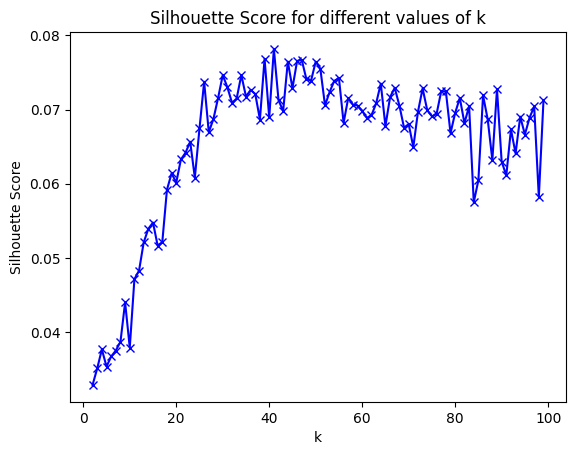

In [139]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Range of k values to evaluate
Ks = range(2, 100)
silhouette_scores = []

for k in Ks:
    model = KMeans(n_clusters=k, max_iter=50, random_state=42)
    model.fit(vectors)
    silhouette_avg = silhouette_score(vectors, model.labels_)
    silhouette_scores.append(silhouette_avg)

# Plotting
plt.plot(Ks, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different values of k')
plt.show()


It seems that the most effective K value hovers around 40 clusters. This is the value that will be used for the final model. Let's test it out.

In [143]:
curr_k = 40

model = KMeans(n_clusters=curr_k, max_iter=100, n_init=1)

model.fit(vectors)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}")
    for ind in order_centroids[i, :10]:
        print(f" {terms[ind]}")
    print("\n")

Cluster 0
 post
 content
 instagram
 create
 job
 posts
 videos
 company
 week
 make


Cluster 1
 page
 instagram
 facebook
 business
 content
 new
 work
 website
 create
 posts


Cluster 2
 experience
 work
 working
 time
 online
 content
 english
 facebook
 team
 platforms


Cluster 3
 tiktok
 ads
 campaigns
 job
 client
 clients
 run
 requirements
 experience
 results


Cluster 4
 create
 content
 manage
 instagram
 strategy
 audience
 able
 videos
 work
 posts




The results seem to be similar to those with K values with a lesser silhouette score.